# **DSR DengAI Project Competition**
# Team: Justin, Adam, Eugene, Paul 

| **Pipeline Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp
import scripts.data_viz as dv

## 1) Pre-process data

In [3]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [4]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [5]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)

print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 45)
train_sj shape: (928, 45)


### Charting different features 

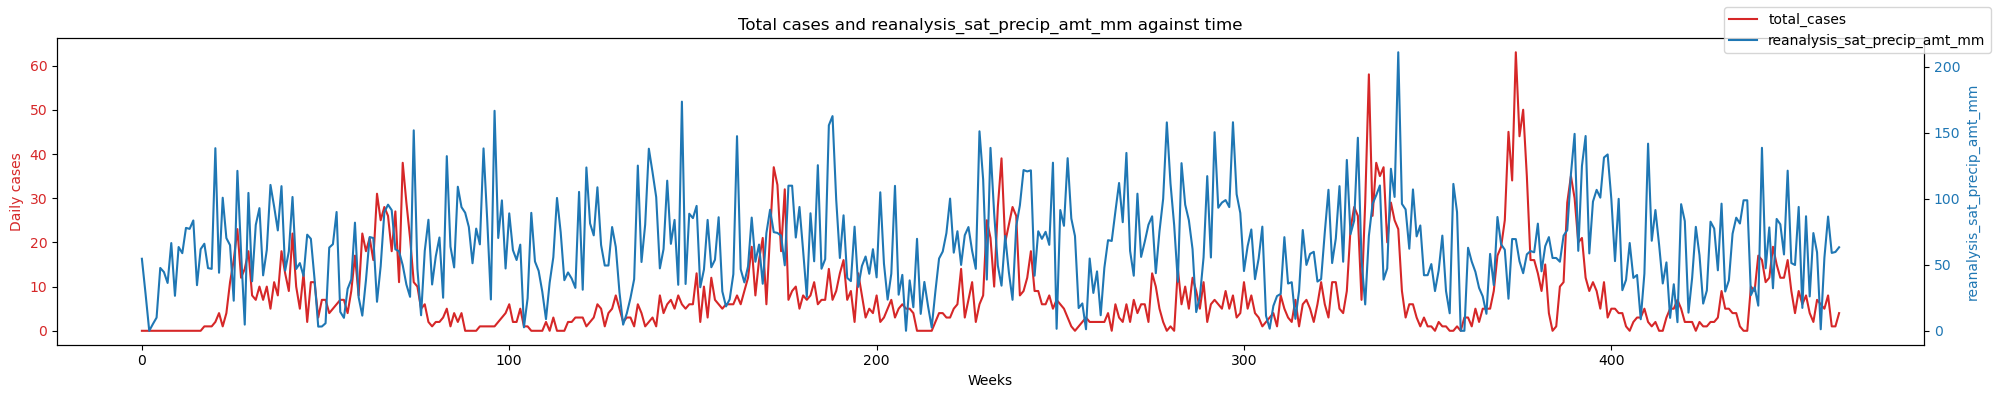

In [6]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'reanalysis_sat_precip_amt_mm'
dv.feature_output_chart(data, y, feature, city='iq')


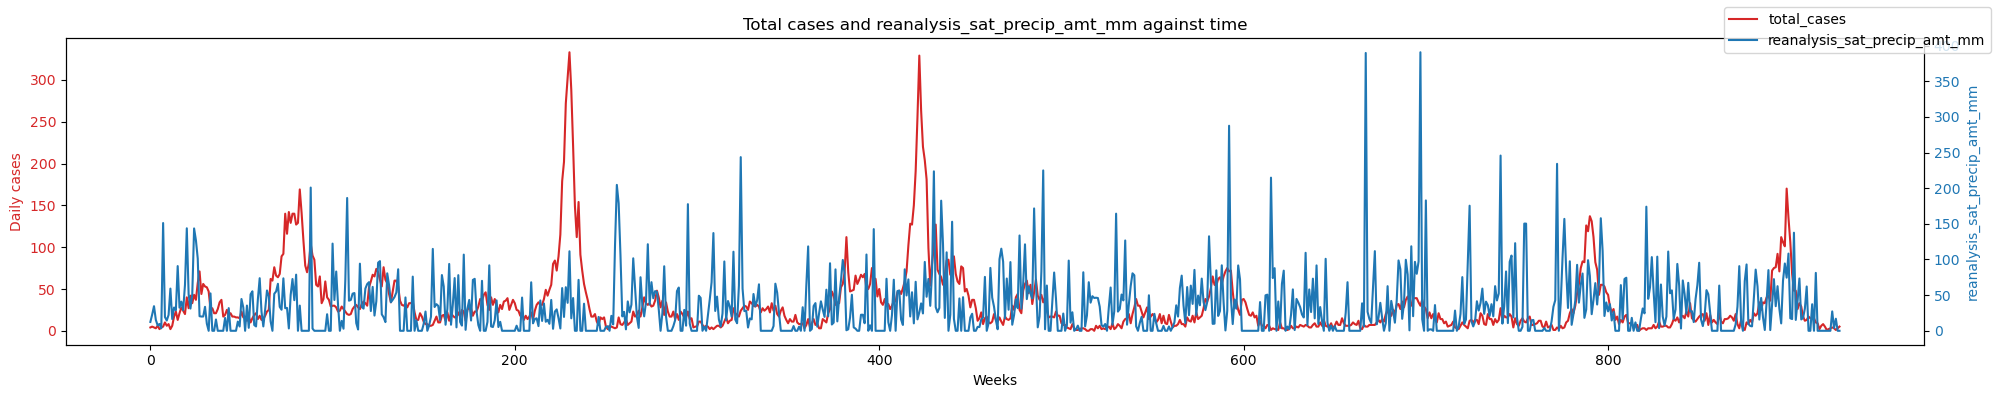

In [7]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'reanalysis_sat_precip_amt_mm'
dv.feature_output_chart(data, y, feature, city='sj')

### Utilising rolling averages 

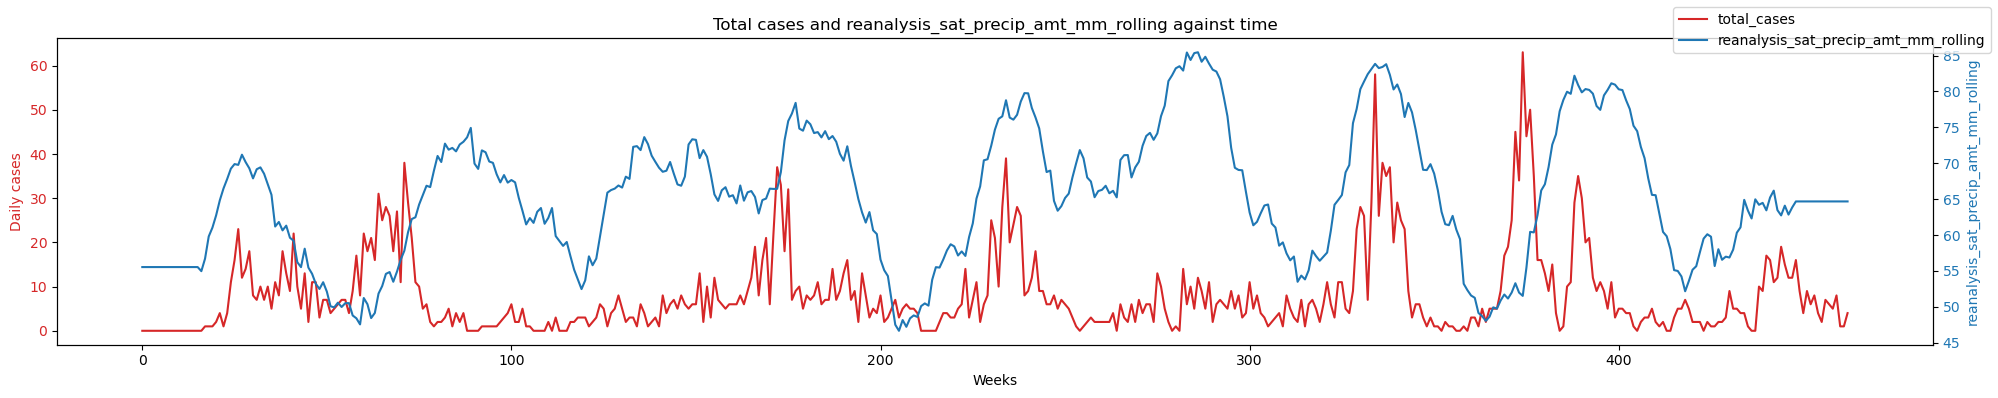

In [8]:
data = Xy_iq
y = Xy_iq['total_cases']
feature = 'reanalysis_sat_precip_amt_mm_rolling'
dv.feature_output_chart(data, y, feature, city='iq')


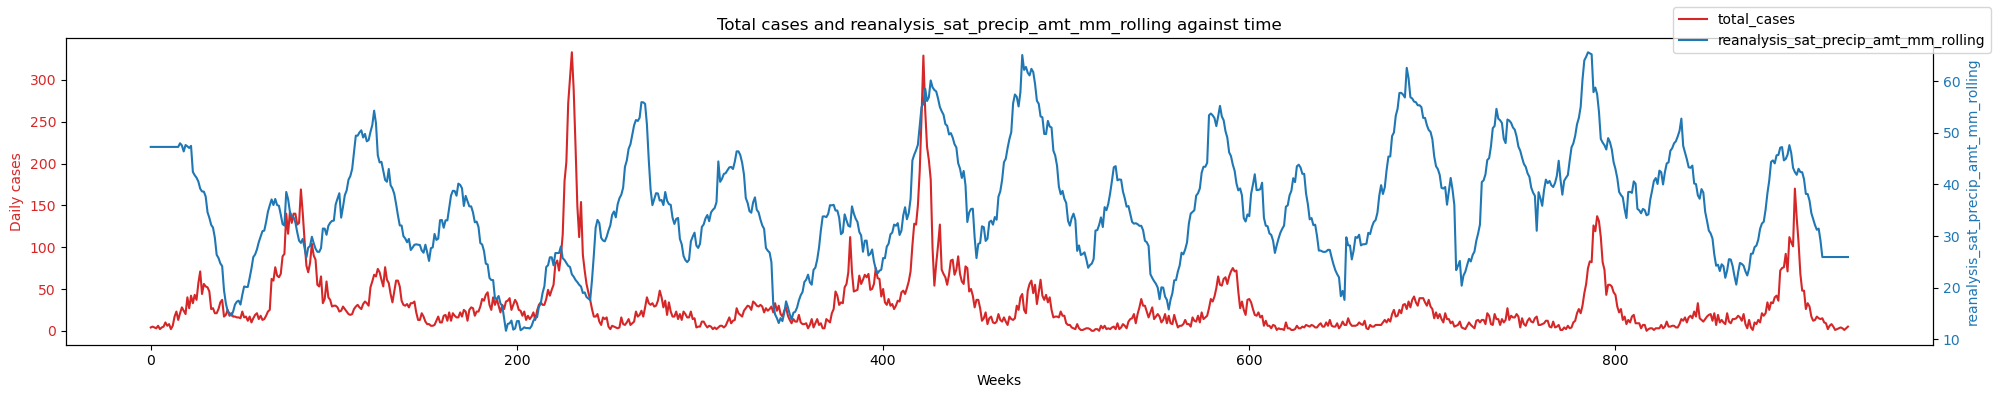

In [9]:
data = Xy_sj
y = Xy_sj['total_cases']
feature = 'reanalysis_sat_precip_amt_mm_rolling'
dv.feature_output_chart(data, y, feature, city='sj')

### Select features that we want for the model

In [10]:
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)

Text(0.5, 1.0, 'San Juan Variable Correlations')

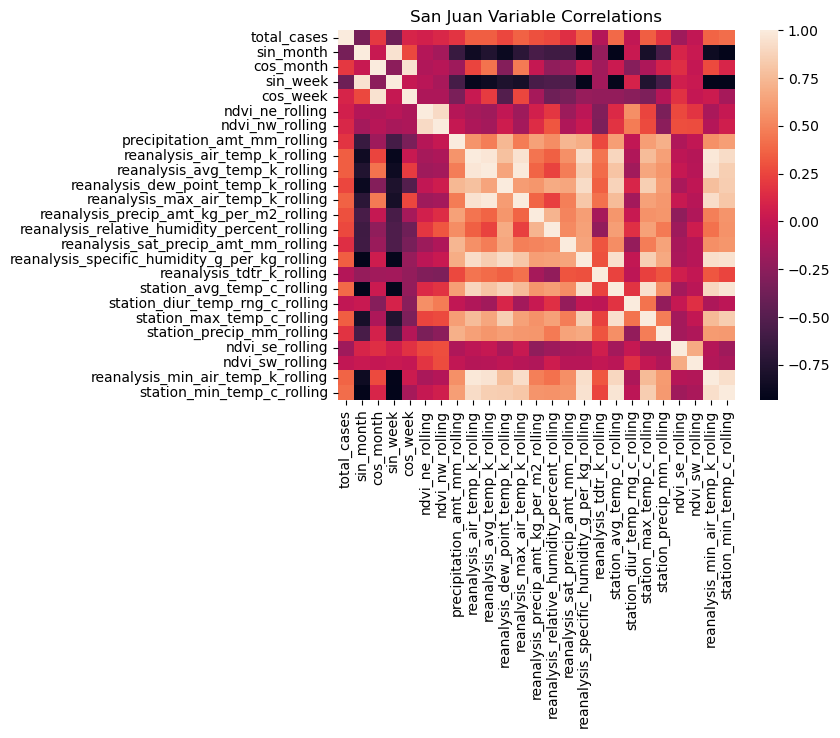

In [11]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')

## 3) Train models

In [12]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

### Baseline model
For Iquitos:  MAE 6.4

For San Juan: MAE 24.3

In [13]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [14]:
warnings.filterwarnings('ignore') 
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.576190,5.316031,5.373600,3.872884,0.6,100
1,1,8.096323,4.960936,5.067012,3.647928,0.6,200
2,1,8.294175,5.123518,5.121802,3.717880,1.0,100
3,1,8.220667,5.107643,5.063550,3.717322,1.0,200
4,2,12.650234,6.336909,8.964965,4.396906,0.6,100
5,2,12.535568,6.113081,8.534592,4.315687,0.6,200
6,2,12.540463,6.216379,8.877531,4.364108,1.0,100
7,2,12.549908,6.175696,8.787398,4.325552,1.0,200


In [15]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,87.113995,20.791679,58.765878,13.583326,0.6,100
1,1,91.896139,19.085858,63.524903,12.844904,0.6,200
2,1,82.323681,21.757303,56.833687,14.261668,1.0,100
3,1,85.281049,20.139886,57.127404,13.320107,1.0,200
4,2,31.731023,37.242385,24.354296,21.699223,0.6,100
5,2,35.168707,35.357890,26.735870,21.028602,0.6,200
6,2,33.009668,37.474315,25.169893,21.779592,1.0,100
7,2,30.473917,36.568791,23.401722,21.394172,1.0,200


<Axes: >

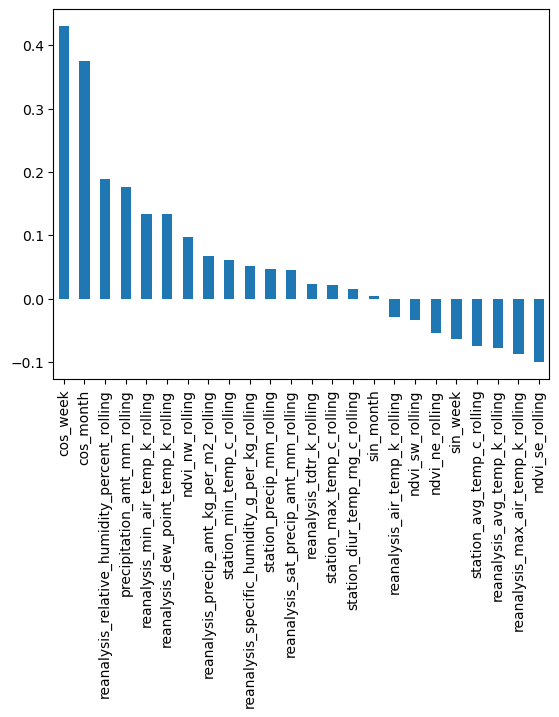

In [16]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

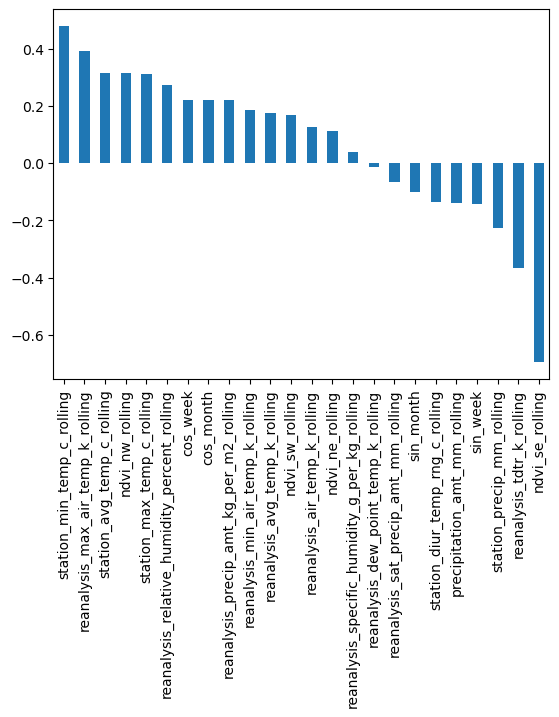

In [17]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [18]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,8.181490,3.504394,5.475854,2.526439,100,4,2,2
1,1,7.945381,3.564800,5.227640,2.530365,100,4,5,2
2,1,8.068360,2.394633,5.387046,1.601604,100,8,2,2
3,1,8.071026,2.590311,5.289751,1.689612,100,8,5,2
4,1,8.055322,3.553344,5.259744,2.559998,200,4,2,2
5,1,7.988404,3.594437,5.235343,2.589638,200,4,5,2
6,1,8.123338,2.482408,5.427519,1.616258,200,8,2,2
7,1,8.080445,2.685192,5.328464,1.730054,200,8,5,2
8,2,11.481997,4.916773,7.225613,3.452076,100,4,2,2
9,2,11.574565,4.912687,7.175270,3.448518,100,4,5,2


<Axes: >

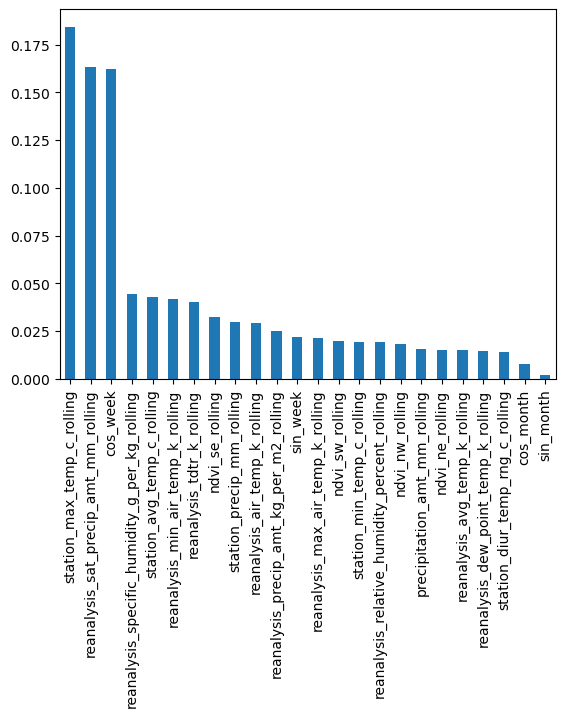

In [19]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

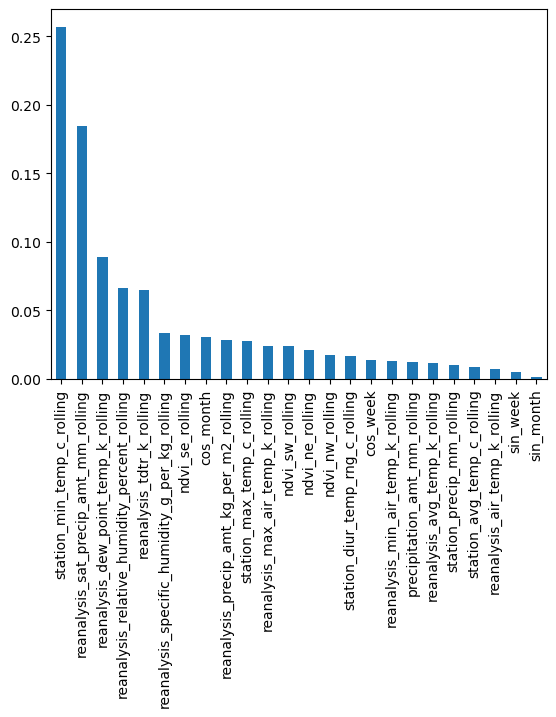

In [20]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [21]:
# XG boost model for iq
X, y = X_iq, y_iq
score, plots = tm.xg_model(X, y)
score

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,8.600413,2.219803,5.605889,1.321076,0.05,100,4,0.6,0.8,5,10
1,1,8.541394,2.708503,5.552896,1.612294,0.05,100,4,0.6,0.8,10,10
2,1,8.490269,3.368976,5.613201,1.935281,0.05,100,4,0.6,0.8,20,10
3,1,8.537074,2.120537,5.514380,1.221403,0.05,100,5,0.6,0.8,5,10
4,1,8.524680,2.665326,5.552544,1.530464,0.05,100,5,0.6,0.8,10,10
5,1,8.495934,3.309181,5.602130,1.860147,0.05,100,5,0.6,0.8,20,10
6,1,8.561950,2.111865,5.548569,1.230183,0.05,100,6,0.6,0.8,5,10
7,1,8.586390,2.635225,5.609285,1.512414,0.05,100,6,0.6,0.8,10,10
8,1,8.486415,3.279038,5.638157,1.839867,0.05,100,6,0.6,0.8,20,10
9,2,11.893137,2.645976,7.372844,1.753246,0.05,100,4,0.6,0.8,5,10


In [23]:
y_pred = plots[0]['pred_train']
y = plots[0]['y_train']
test_or_train = 'Train'
dv.plot_train_test(data, y, feature:, test_or_train=test_or_train)

array([-3.61660942e-02, -3.61660942e-02, -3.61660942e-02, -3.61660942e-02,
       -3.61660942e-02, -3.03664133e-02, -3.03664133e-02, -3.03664133e-02,
       -3.03664133e-02, -7.03122467e-02,  2.71501429e-02,  2.40475789e-01,
       -9.90294665e-02, -1.41430601e-01, -1.41430601e-01, -1.41430601e-01,
        6.62412345e-01,  7.12094307e-01,  7.98375607e-01,  1.17720318e+00,
        2.16621614e+00,  3.24609089e+00,  3.20472217e+00,  5.84594774e+00,
        1.06829185e+01,  1.64889240e+01,  1.78546829e+01,  1.15099354e+01,
        1.23197298e+01,  1.20728111e+01,  7.91047382e+00,  7.49434614e+00,
        1.01027679e+01,  7.95606184e+00,  9.87057114e+00,  6.88932896e+00,
        9.48648739e+00,  8.93309212e+00,  1.52037115e+01,  1.41958141e+01,
        1.17611704e+01,  1.49226246e+01,  9.54027271e+00,  8.45278835e+00,
        1.04458857e+01,  6.30875492e+00,  9.73563766e+00,  9.42332649e+00,
        6.06473541e+00,  5.76210165e+00,  5.16037941e+00,  3.84080815e+00,
        4.82452488e+00,  

In [ ]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [ ]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


In [ ]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=100,
        max_depth=5,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=10,
        gamma=10)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [ ]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [ ]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

In [ ]:
plt.figure(figsize=(16,4))
x = np.arange(468)
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

In [ ]:
plt.figure(figsize=(16,4))
x = np.arange(928)
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

In [ ]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_XGB_no_shift.csv', index=False)